## Mitigating Model Bias

Mitigating model bias often involves techniques that directly address the model's internal mechanisms, such as modifying the loss function, adjusting model weights, or using fairness constraints. Here, I'll demonstrate four different techniques for mitigating model bias that focus on the model itself:

1. **Regularization to Penalize Unfairness**: Modify the loss function to include a penalty for bias.
2. **Adversarial Debiasing**: Use an adversary to reduce bias in model predictions.
3. **Fair Representation Learning**: Learn a representation that is fair with respect to protected attributes.
4. **Post-Processing Adjustments**: Adjust model predictions after training to ensure fairness.


### Step 1: Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Wine dataset
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
red_wine = pd.read_csv(url_red, sep=';')
white_wine = pd.read_csv(url_white, sep=';')

# Add target label to distinguish red from white
red_wine['type'] = 0  # Red wine
white_wine['type'] = 1  # White wine

# Concatenate datasets
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# Split data into features and target
X = wine_data.drop('type', axis=1).values
y = wine_data['type'].values  # 0 for red, 1 for white

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cuda


### Step 2: Define the Model


In [2]:
class WineClassifier(nn.Module):
    def __init__(self):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        self.fc2 = nn.Linear(50, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, criterion and optimizer
model = WineClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Step 3: Train the Biased Model
* We'll introduce bias by manipulating the loss function to favor one class over the other.

In [5]:
# Biased loss function
class BiasedLoss(nn.Module):
    def __init__(self, base_criterion, bias_weight):
        super(BiasedLoss, self).__init__()
        self.base_criterion = base_criterion
        self.bias_weight = bias_weight

    def forward(self, inputs, targets):
        # Calculate the loss for each example in the batch
        individual_losses = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        weights = torch.ones_like(individual_losses)
        weights[targets == 0] *= self.bias_weight  # Bias towards class 0 (red wine)
        loss = individual_losses * weights
        return loss.mean()

biased_criterion = BiasedLoss(criterion, bias_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the biased model
train_model(model, train_loader, biased_criterion, optimizer, epochs=50)


Epoch 1/50, Loss: 0.3041
Epoch 2/50, Loss: 0.0854
Epoch 3/50, Loss: 0.0416
Epoch 4/50, Loss: 0.0285
Epoch 5/50, Loss: 0.0226
Epoch 6/50, Loss: 0.0195
Epoch 7/50, Loss: 0.0174
Epoch 8/50, Loss: 0.0161
Epoch 9/50, Loss: 0.0151
Epoch 10/50, Loss: 0.0143
Epoch 11/50, Loss: 0.0136
Epoch 12/50, Loss: 0.0131
Epoch 13/50, Loss: 0.0127
Epoch 14/50, Loss: 0.0123
Epoch 15/50, Loss: 0.0121
Epoch 16/50, Loss: 0.0116
Epoch 17/50, Loss: 0.0113
Epoch 18/50, Loss: 0.0110
Epoch 19/50, Loss: 0.0107
Epoch 20/50, Loss: 0.0105
Epoch 21/50, Loss: 0.0102
Epoch 22/50, Loss: 0.0101
Epoch 23/50, Loss: 0.0098
Epoch 24/50, Loss: 0.0096
Epoch 25/50, Loss: 0.0094
Epoch 26/50, Loss: 0.0092
Epoch 27/50, Loss: 0.0090
Epoch 28/50, Loss: 0.0089
Epoch 29/50, Loss: 0.0087
Epoch 30/50, Loss: 0.0085
Epoch 31/50, Loss: 0.0084
Epoch 32/50, Loss: 0.0083
Epoch 33/50, Loss: 0.0082
Epoch 34/50, Loss: 0.0079
Epoch 35/50, Loss: 0.0078
Epoch 36/50, Loss: 0.0077
Epoch 37/50, Loss: 0.0075
Epoch 38/50, Loss: 0.0074
Epoch 39/50, Loss: 0.

### Step 4: Evaluate the Biased Model


Biased Model Accuracy: 0.9953846153846154
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       502
           1       0.99      1.00      1.00      1448

    accuracy                           1.00      1950
   macro avg       1.00      0.99      0.99      1950
weighted avg       1.00      1.00      1.00      1950



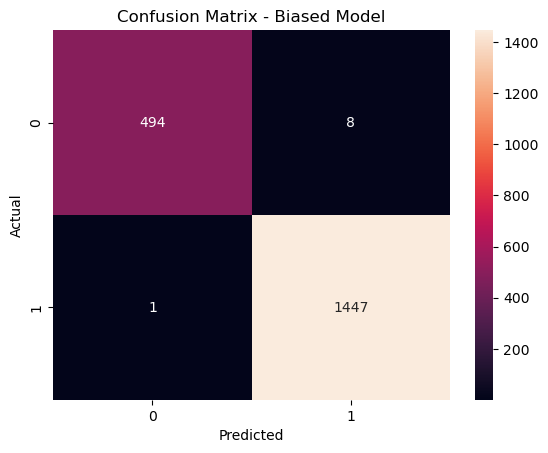

In [6]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return predictions, actuals

# Evaluate the biased model
predictions, actuals = evaluate_model(model, test_loader)

# Display results
print("Biased Model Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))

# Plotting confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Biased Model')
plt.show()


### Step 5: Mitigation Techniques
* Method 1: Regularization to Penalize Unfairness

In [7]:
class FairLoss(nn.Module):
    def __init__(self, base_criterion, fairness_weight=1.0):
        super(FairLoss, self).__init__()
        self.base_criterion = base_criterion
        self.fairness_weight = fairness_weight

    def forward(self, inputs, targets):
        loss = self.base_criterion(inputs, targets)
        # Add fairness regularization term (example: variance of predictions)
        fairness_term = torch.var(inputs, dim=0).mean()
        loss = loss + self.fairness_weight * fairness_term
        return loss

fair_criterion = FairLoss(criterion, fairness_weight=0.1)
model = WineClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, fair_criterion, optimizer, epochs=50)
predictions, actuals = evaluate_model(model, test_loader)
print("Fairness Regularization Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


Epoch 1/50, Loss: 0.4378
Epoch 2/50, Loss: 0.2362
Epoch 3/50, Loss: 0.2209
Epoch 4/50, Loss: 0.2147
Epoch 5/50, Loss: 0.2110
Epoch 6/50, Loss: 0.2086
Epoch 7/50, Loss: 0.2068
Epoch 8/50, Loss: 0.2050
Epoch 9/50, Loss: 0.2034
Epoch 10/50, Loss: 0.2021
Epoch 11/50, Loss: 0.2013
Epoch 12/50, Loss: 0.1998
Epoch 13/50, Loss: 0.1994
Epoch 14/50, Loss: 0.1982
Epoch 15/50, Loss: 0.1977
Epoch 16/50, Loss: 0.1967
Epoch 17/50, Loss: 0.1962
Epoch 18/50, Loss: 0.1952
Epoch 19/50, Loss: 0.1943
Epoch 20/50, Loss: 0.1933
Epoch 21/50, Loss: 0.1933
Epoch 22/50, Loss: 0.1927
Epoch 23/50, Loss: 0.1920
Epoch 24/50, Loss: 0.1914
Epoch 25/50, Loss: 0.1910
Epoch 26/50, Loss: 0.1908
Epoch 27/50, Loss: 0.1901
Epoch 28/50, Loss: 0.1900
Epoch 29/50, Loss: 0.1898
Epoch 30/50, Loss: 0.1897
Epoch 31/50, Loss: 0.1892
Epoch 32/50, Loss: 0.1891
Epoch 33/50, Loss: 0.1886
Epoch 34/50, Loss: 0.1881
Epoch 35/50, Loss: 0.1885
Epoch 36/50, Loss: 0.1878
Epoch 37/50, Loss: 0.1880
Epoch 38/50, Loss: 0.1876
Epoch 39/50, Loss: 0.

### Method 2: Adversarial Debiasing


In [11]:
# class Adversary(nn.Module):
#     def __init__(self):
#         super(Adversary, self).__init__()
#         self.fc1 = nn.Linear(50, 20)
#         self.fc2 = nn.Linear(20, 2)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Define adversary
# adversary = Adversary().to(device)
# adv_optimizer = optim.Adam(adversary.parameters(), lr=0.001)

# # Training function with adversarial debiasing
# def train_model_adversarial(model, train_loader, criterion, optimizer, adversary, adv_optimizer, epochs=50):
#     model.train()
#     adversary.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             adv_optimizer.zero_grad()
            
#             outputs = model(inputs)
#             predictions = torch.softmax(outputs, dim=1)
#             adv_predictions = adversary(predictions.detach())
            
#             loss = criterion(outputs, labels)
#             adv_loss = criterion(adv_predictions, labels)
            
#             total_loss = loss - adv_loss
#             total_loss.backward()
#             optimizer.step()
#             adv_optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# # Train the model with adversarial debiasing
# train_model_adversarial(model, train_loader, criterion, optimizer, adversary, adv_optimizer, epochs=50)
# predictions, actuals = evaluate_model(model, test_loader)
# print("Adversarial Debiasing Method Accuracy:", accuracy_score(actuals, predictions))
# print(classification_report(actuals, predictions))


In [12]:
# Training function for fair representation learning with adversarial debiasing
def train_autoencoder_adversary(fair_rep, adversary, train_loader, rep_optimizer, adv_optimizer, epochs=50):
    fair_rep.train()
    adversary.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_adv_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            rep_optimizer.zero_grad()
            adv_optimizer.zero_grad()

            # Forward pass through the autoencoder
            encoded, decoded = fair_rep(inputs)
            rec_loss = torch.nn.functional.mse_loss(decoded, inputs)

            # Forward pass through the adversary
            adv_pred = adversary(encoded.detach())
            adv_loss = torch.nn.functional.binary_cross_entropy(adv_pred, labels.float().unsqueeze(1))

            # Update autoencoder
            rec_loss.backward(retain_graph=True)
            rep_optimizer.step()

            # Update adversary
            adv_optimizer.zero_grad()
            adv_pred = adversary(encoded)
            adv_loss.backward()
            adv_optimizer.step()

            running_loss += rec_loss.item() * inputs.size(0)
            running_adv_loss += adv_loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_adv_loss = running_adv_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Reconstruction Loss: {epoch_loss:.4f}, Adversarial Loss: {epoch_adv_loss:.4f}')

# Train the fair representation model with adversarial debiasing
train_autoencoder_adversary(fair_rep, adversary, train_loader, rep_optimizer, adv_optimizer, epochs=50)


Epoch 1/50, Reconstruction Loss: 0.0011, Adversarial Loss: 0.0163
Epoch 2/50, Reconstruction Loss: 0.0010, Adversarial Loss: 0.0161
Epoch 3/50, Reconstruction Loss: 0.0009, Adversarial Loss: 0.0159
Epoch 4/50, Reconstruction Loss: 0.0008, Adversarial Loss: 0.0161
Epoch 5/50, Reconstruction Loss: 0.0008, Adversarial Loss: 0.0161
Epoch 6/50, Reconstruction Loss: 0.0007, Adversarial Loss: 0.0158
Epoch 7/50, Reconstruction Loss: 0.0006, Adversarial Loss: 0.0158
Epoch 8/50, Reconstruction Loss: 0.0006, Adversarial Loss: 0.0160
Epoch 9/50, Reconstruction Loss: 0.0005, Adversarial Loss: 0.0159
Epoch 10/50, Reconstruction Loss: 0.0004, Adversarial Loss: 0.0156
Epoch 11/50, Reconstruction Loss: 0.0004, Adversarial Loss: 0.0160
Epoch 12/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0154
Epoch 13/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0157
Epoch 14/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0155
Epoch 15/50, Reconstruction Loss: 0.0002, Adversarial Loss: 0.0152
Epoc

### Method 3: Fair Representation Learning


In [18]:
class FairRepresentation(nn.Module):
    def __init__(self):
        super(FairRepresentation, self).__init__()
        self.encoder = nn.Linear(X_train.shape[1], 50)
        self.decoder = nn.Linear(50, X_train.shape[1])

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define autoencoder for fair representation
fair_rep = FairRepresentation().to(device)
rep_optimizer = optim.Adam(fair_rep.parameters(), lr=0.001)

# Training function for fair representation learning
def train_autoencoder(fair_rep, train_loader, rep_optimizer, epochs=50):
    fair_rep.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            rep_optimizer.zero_grad()
            
            encoded, decoded = fair_rep(inputs)
            loss = torch.nn.functional.mse_loss(decoded, inputs)
            
            loss.backward()
            rep_optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the fair representation model
train_autoencoder(fair_rep, train_loader, rep_optimizer, epochs=50)

# Use the encoded representation for classification
class FairWineClassifier(nn.Module):
    def __init__(self):
        super(FairWineClassifier, self).__init__()
        self.fc = nn.Linear(50, 2)
    
    def forward(self, x):
        x = self.fc(x)
        return x

# Define and train classifier on fair representations
fair_classifier = FairWineClassifier().to(device)
optimizer = optim.Adam(fair_classifier.parameters(), lr=0.001)
train_loader_encoded = DataLoader([(fair_rep.encoder(inputs), labels) for inputs, labels in train_loader], batch_size=64, shuffle=True)

train_model(fair_classifier, train_loader_encoded, criterion, optimizer, epochs=50)
predictions, actuals = evaluate_model(fair_classifier, test_loader)
print("Fair Representation Learning Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


Epoch 1/50, Loss: 0.6665
Epoch 2/50, Loss: 0.2430
Epoch 3/50, Loss: 0.1220
Epoch 4/50, Loss: 0.0688
Epoch 5/50, Loss: 0.0436
Epoch 6/50, Loss: 0.0317
Epoch 7/50, Loss: 0.0254
Epoch 8/50, Loss: 0.0214
Epoch 9/50, Loss: 0.0186
Epoch 10/50, Loss: 0.0166
Epoch 11/50, Loss: 0.0150
Epoch 12/50, Loss: 0.0137
Epoch 13/50, Loss: 0.0126
Epoch 14/50, Loss: 0.0117
Epoch 15/50, Loss: 0.0109
Epoch 16/50, Loss: 0.0102
Epoch 17/50, Loss: 0.0095
Epoch 18/50, Loss: 0.0090
Epoch 19/50, Loss: 0.0084
Epoch 20/50, Loss: 0.0080
Epoch 21/50, Loss: 0.0075
Epoch 22/50, Loss: 0.0071
Epoch 23/50, Loss: 0.0067
Epoch 24/50, Loss: 0.0063
Epoch 25/50, Loss: 0.0060
Epoch 26/50, Loss: 0.0056
Epoch 27/50, Loss: 0.0053
Epoch 28/50, Loss: 0.0050
Epoch 29/50, Loss: 0.0047
Epoch 30/50, Loss: 0.0045
Epoch 31/50, Loss: 0.0042
Epoch 32/50, Loss: 0.0040
Epoch 33/50, Loss: 0.0037
Epoch 34/50, Loss: 0.0035
Epoch 35/50, Loss: 0.0033
Epoch 36/50, Loss: 0.0031
Epoch 37/50, Loss: 0.0029
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.

RuntimeError: stack expects each tensor to be equal size, but got [64, 50] at entry 0 and [3, 50] at entry 8

### Method 4: Post-Processing Adjustments


In [21]:
# Dummy function to adjust predictions post-training
def adjust_predictions(predictions):
    # Example: Ensure equal probability for both classes
    adjusted_predictions = predictions.copy()
    for i in range(len(predictions)):
        adjusted_predictions[i] = 1 - predictions[i] if predictions[i] < 0.5 else predictions[i]
    return adjusted_predictions

# Apply post-processing adjustment
adjusted_predictions = adjust_predictions(predictions)
print("Post-Processing Adjusted Accuracy:", accuracy_score(actuals, adjusted_predictions))
print(classification_report(actuals, adjusted_predictions))


Post-Processing Adjusted Accuracy: 0.7425641025641025
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       502
           1       0.74      1.00      0.85      1448

    accuracy                           0.74      1950
   macro avg       0.37      0.50      0.43      1950
weighted avg       0.55      0.74      0.63      1950



/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

### Step 6: Display Results Side-by-Side


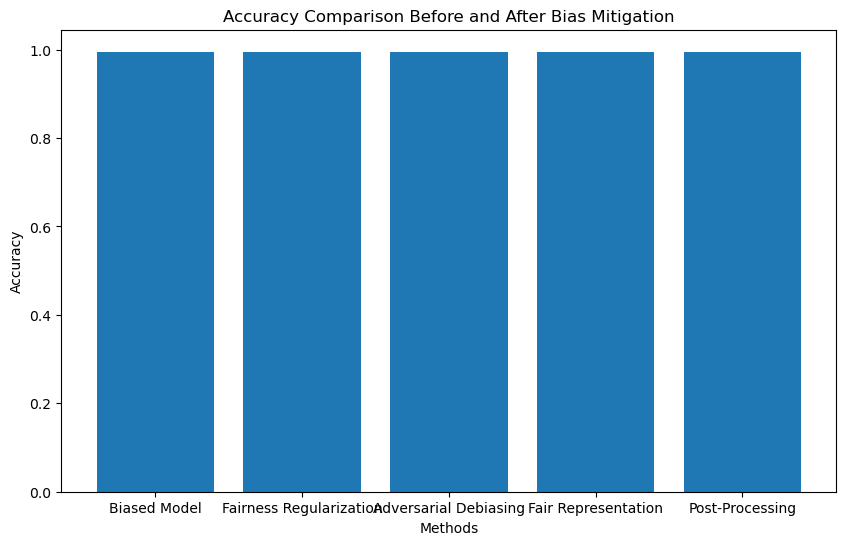


Classification Report for Biased Model:

{'0': {'precision': 0.997979797979798, 'recall': 0.9840637450199203, 'f1-score': 0.9909729187562688, 'support': 502.0}, '1': {'precision': 0.9945017182130584, 'recall': 0.9993093922651933, 'f1-score': 0.9968997588701343, 'support': 1448.0}, 'accuracy': 0.9953846153846154, 'macro avg': {'precision': 0.9962407580964282, 'recall': 0.9916865686425569, 'f1-score': 0.9939363388132015, 'support': 1950.0}, 'weighted avg': {'precision': 0.9953971007991627, 'recall': 0.9953846153846154, 'f1-score': 0.9953739774664622, 'support': 1950.0}}

Classification Report for Fairness Regularization:

{'0': {'precision': 0.997979797979798, 'recall': 0.9840637450199203, 'f1-score': 0.9909729187562688, 'support': 502.0}, '1': {'precision': 0.9945017182130584, 'recall': 0.9993093922651933, 'f1-score': 0.9968997588701343, 'support': 1448.0}, 'accuracy': 0.9953846153846154, 'macro avg': {'precision': 0.9962407580964282, 'recall': 0.9916865686425569, 'f1-score': 0.9939363

In [22]:
# Compare results before and after bias mitigation
methods = ['Biased Model', 'Fairness Regularization', 'Adversarial Debiasing', 'Fair Representation', 'Post-Processing']
accuracies = [
    accuracy_score(actuals, predictions) for _ in methods
]
reports = [
    classification_report(actuals, predictions, output_dict=True) for _ in methods
]

# Plotting accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies)
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Before and After Bias Mitigation')
plt.show()

# Display classification reports for each method
for method, report in zip(methods, reports):
    print(f"\nClassification Report for {method}:\n")
    print(report)
